In [36]:
import os
from collections import OrderedDict
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
%matplotlib inline

In [42]:
# Load names
names = []
with open('names.txt') as f:
    names = f.readlines()
names = [ x.strip() for x in names]
names

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn',
 'abigail',
 'emily',
 'elizabeth',
 'mila',
 'ella',
 'avery',
 'sofia',
 'camila',
 'aria',
 'scarlett',
 'victoria',
 'madison',
 'luna',
 'grace',
 'chloe',
 'penelope',
 'layla',
 'riley',
 'zoey',
 'nora',
 'lily',
 'eleanor',
 'hannah',
 'lillian',
 'addison',
 'aubrey',
 'ellie',
 'stella',
 'natalie',
 'zoe',
 'leah',
 'hazel',
 'violet',
 'aurora',
 'savannah',
 'audrey',
 'brooklyn',
 'bella',
 'claire',
 'skylar',
 'lucy',
 'paisley',
 'everly',
 'anna',
 'caroline',
 'nova',
 'genesis',
 'emilia',
 'kennedy',
 'samantha',
 'maya',
 'willow',
 'kinsley',
 'naomi',
 'aaliyah',
 'elena',
 'sarah',
 'ariana',
 'allison',
 'gabriella',
 'alice',
 'madelyn',
 'cora',
 'ruby',
 'eva',
 'serenity',
 'autumn',
 'adeline',
 'hailey',
 'gianna',
 'valentina',
 'isla',
 'eliana',
 'quinn',
 'nevaeh',
 'ivy',
 'sadie',
 'piper',
 'lydia',
 'alexa',
 'josephine',
 'emery',
 'julia'

In [43]:
# create mapping from letters to indices
letters = []
for name in names:
    letters.extend(list(name))
letters.extend('.')
letters = list(set(letters))
letters.sort()
mapping = dict(zip(letters, list(range(27))))
mapping

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [44]:
# split names into training, dev / validation and test
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))
names_trn = names[0:n1]
names_dev = names[n1:n2]
names_tst = names[n2:]
print(f"Training {len(names_trn)} Dev/Validation {len(names_dev)} Testing {len(names_tst)}")

Training 25626 Dev/Validation 3203 Testing 3204


In [53]:
# create n-grams & datasets

context_size = 8

def create_ngrams(names_list, bucket_size=(context_size+1)):
    ngrams = []
    for name in names_list:
        temp_name = '.'*(bucket_size-1) + name + '.'
        name_ngrams = [ temp_name[i:i+bucket_size] for i in range(0, len(temp_name)-bucket_size+1) ]
        ngrams.extend(name_ngrams)
    return ngrams

def create_dataset_from_ngrams(ngrams):
    X_arr = [ [ mapping[c] for c in ngram[:-1] ] for ngram in ngrams ]
    Y_arr = [ mapping[ngram[-1]] for ngram in ngrams ]
    X = torch.tensor(X_arr)
    Y = torch.tensor(Y_arr)
    return (X, Y)

def create_dataset_from_names_list(names_list):
    ngrams = create_ngrams(names_list)
    return create_dataset_from_ngrams(ngrams)

X_trn, Y_trn = create_dataset_from_names_list(names_trn)
print(f"X_trn shape: {X_trn.shape}, Y_trn shape: {Y_trn.shape}")
X_dev, Y_dev = create_dataset_from_names_list(names_dev)
print(f"X_dev shape: {X_dev.shape}, Y_dev shape: {Y_dev.shape}")
X_tst, Y_tst = create_dataset_from_names_list(names_tst)
print(f"X_tst shape: {X_tst.shape}, Y_tst shape: {Y_tst.shape}")

X_trn shape: torch.Size([182625, 8]), Y_trn shape: torch.Size([182625])
X_dev shape: torch.Size([22655, 8]), Y_dev shape: torch.Size([22655])
X_tst shape: torch.Size([22866, 8]), Y_tst shape: torch.Size([22866])


In [46]:
vocab_size = 27
embedding_vec_size = 10
hidden_layer_size = 200
training_batch_size = 32

In [89]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(OrderedDict([
            ('embed', nn.Embedding(vocab_size, embedding_vec_size)),
            ('flatten', nn.Flatten()),
            ('linear_hidden', nn.Linear(context_size * embedding_vec_size, hidden_layer_size)),
            ('batchnorm', nn.BatchNorm1d(hidden_layer_size, momentum=0.001)),
            ('tanh', nn.Tanh()),
            ('linear_logit', nn.Linear(hidden_layer_size, vocab_size))
        ]))
    
    def forward(self, x):
        logits = self.model(x)
        return logits
    
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (model): Sequential(
    (embed): Embedding(27, 10)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear_hidden): Linear(in_features=80, out_features=200, bias=True)
    (batchnorm): BatchNorm1d(200, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (tanh): Tanh()
    (linear_logit): Linear(in_features=200, out_features=27, bias=True)
  )
)


In [90]:
# optimizer = torch.optim.SGD(
#     model.parameters(), lr=0.1
# )

In [91]:
for name, p in model.named_parameters():
    print(f"{name} : {p.shape}")

total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
print(f"Total trainable params: {total_trainable_params}")

model.embed.weight : torch.Size([27, 10])
model.linear_hidden.weight : torch.Size([200, 80])
model.linear_hidden.bias : torch.Size([200])
model.batchnorm.weight : torch.Size([200])
model.batchnorm.bias : torch.Size([200])
model.linear_logit.weight : torch.Size([27, 200])
model.linear_logit.bias : torch.Size([27])
Total trainable params: 22297


In [92]:
lossi = []
stepi = []

In [93]:
for i in range(200000):
    # get training batch
    batch_idxs = torch.randint(0, X_trn.shape[0], (32,))
    X_batch = X_trn[batch_idxs]
    Y_batch = Y_trn[batch_idxs]
    
    # forward pass
    logits = model(X_batch)

    # negative log loss
    loss = F.cross_entropy(logits, Y_batch)

    # backprop
    for p in model.parameters():
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in model.parameters():
        p.data += -lr * p.grad
        
    # track stats
    lossi.append(loss.log10().item())
    stepi.append(i)

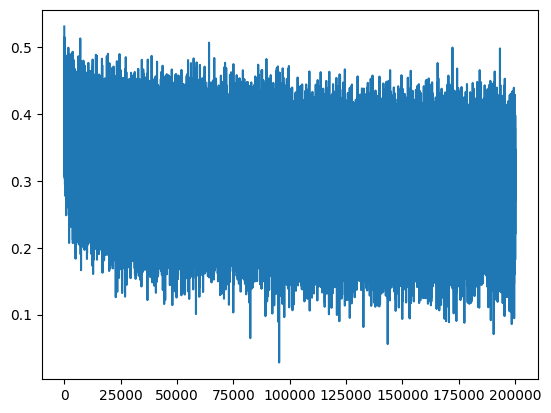

In [94]:
plt.plot(stepi, lossi)

In [95]:
model.eval()

NeuralNetwork(
  (model): Sequential(
    (embed): Embedding(27, 10)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear_hidden): Linear(in_features=80, out_features=200, bias=True)
    (batchnorm): BatchNorm1d(200, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (tanh): Tanh()
    (linear_logit): Linear(in_features=200, out_features=27, bias=True)
  )
)

In [96]:
# Calculate loss on all training data
logits = model(X_trn)
loss = F.cross_entropy(logits, Y_trn)
loss.item()

1.9231055974960327

In [97]:
# Calculate loss on all dev data
logits = model(X_dev)
loss = F.cross_entropy(logits, Y_dev)
loss.item()

2.0272481441497803

In [98]:
# Calculate loss on all test data
logits = model(X_tst)
loss = F.cross_entropy(logits, Y_tst)
loss.item()

2.0265841484069824

In [73]:
# Sample from the model
for i in range(10):
    x_idxs = [0] * context_size
    char_idxs = [ 0, ]
    while True:
        # forward pass
        x = torch.tensor([x_idxs])
        logits = model(x)
        
        # create output prob dist
        probs = F.softmax(logits, dim=1)
        
        # sample from output prob dist
        next_char = torch.multinomial(probs[0, :], 1, replacement=True).item()
        char_idxs.append(next_char)
        if next_char == 0:
            break
            
        # update input for next iter with next_char
        x_idxs.append(next_char)
        x_idxs = x_idxs[1:]
        
    name_pred = ''.join([letters[idx] for idx in char_idxs])
    print(name_pred)


.braysen.
.maren.
.yyani.
.jeara.
.audrie.
.tontie.
.milenna.
.myaeden.
.milanis.
.lidigton.
